In [36]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib
import os

In [57]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [38]:
# Function to filter out directories starting with "Tomato__"
def filter_directories(dir):
    return dir.startswith("Tomato_")
# Get a list of directories in "PlantVillage"
directories = [d for d in os.listdir("PlantVillage") if os.path.isdir(os.path.join("PlantVillage", d))]

# Filter the directories
include_dirs = [d for d in directories if filter_directories(d)]
print(include_dirs)
# Generate the dataset by specifying the filter function
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_names=include_dirs
)


['Tomato_healthy', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_Bacterial_spot', 'Tomato_Late_blight']
Found 16011 files belonging to 10 classes.


In [39]:
class_names= dataset.class_names
class_names

['Tomato_healthy',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Tomato_Leaf_Mold',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Bacterial_spot',
 'Tomato_Late_blight']

In [40]:
len(dataset)

501

In [41]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

2024-05-09 11:39:16.436067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


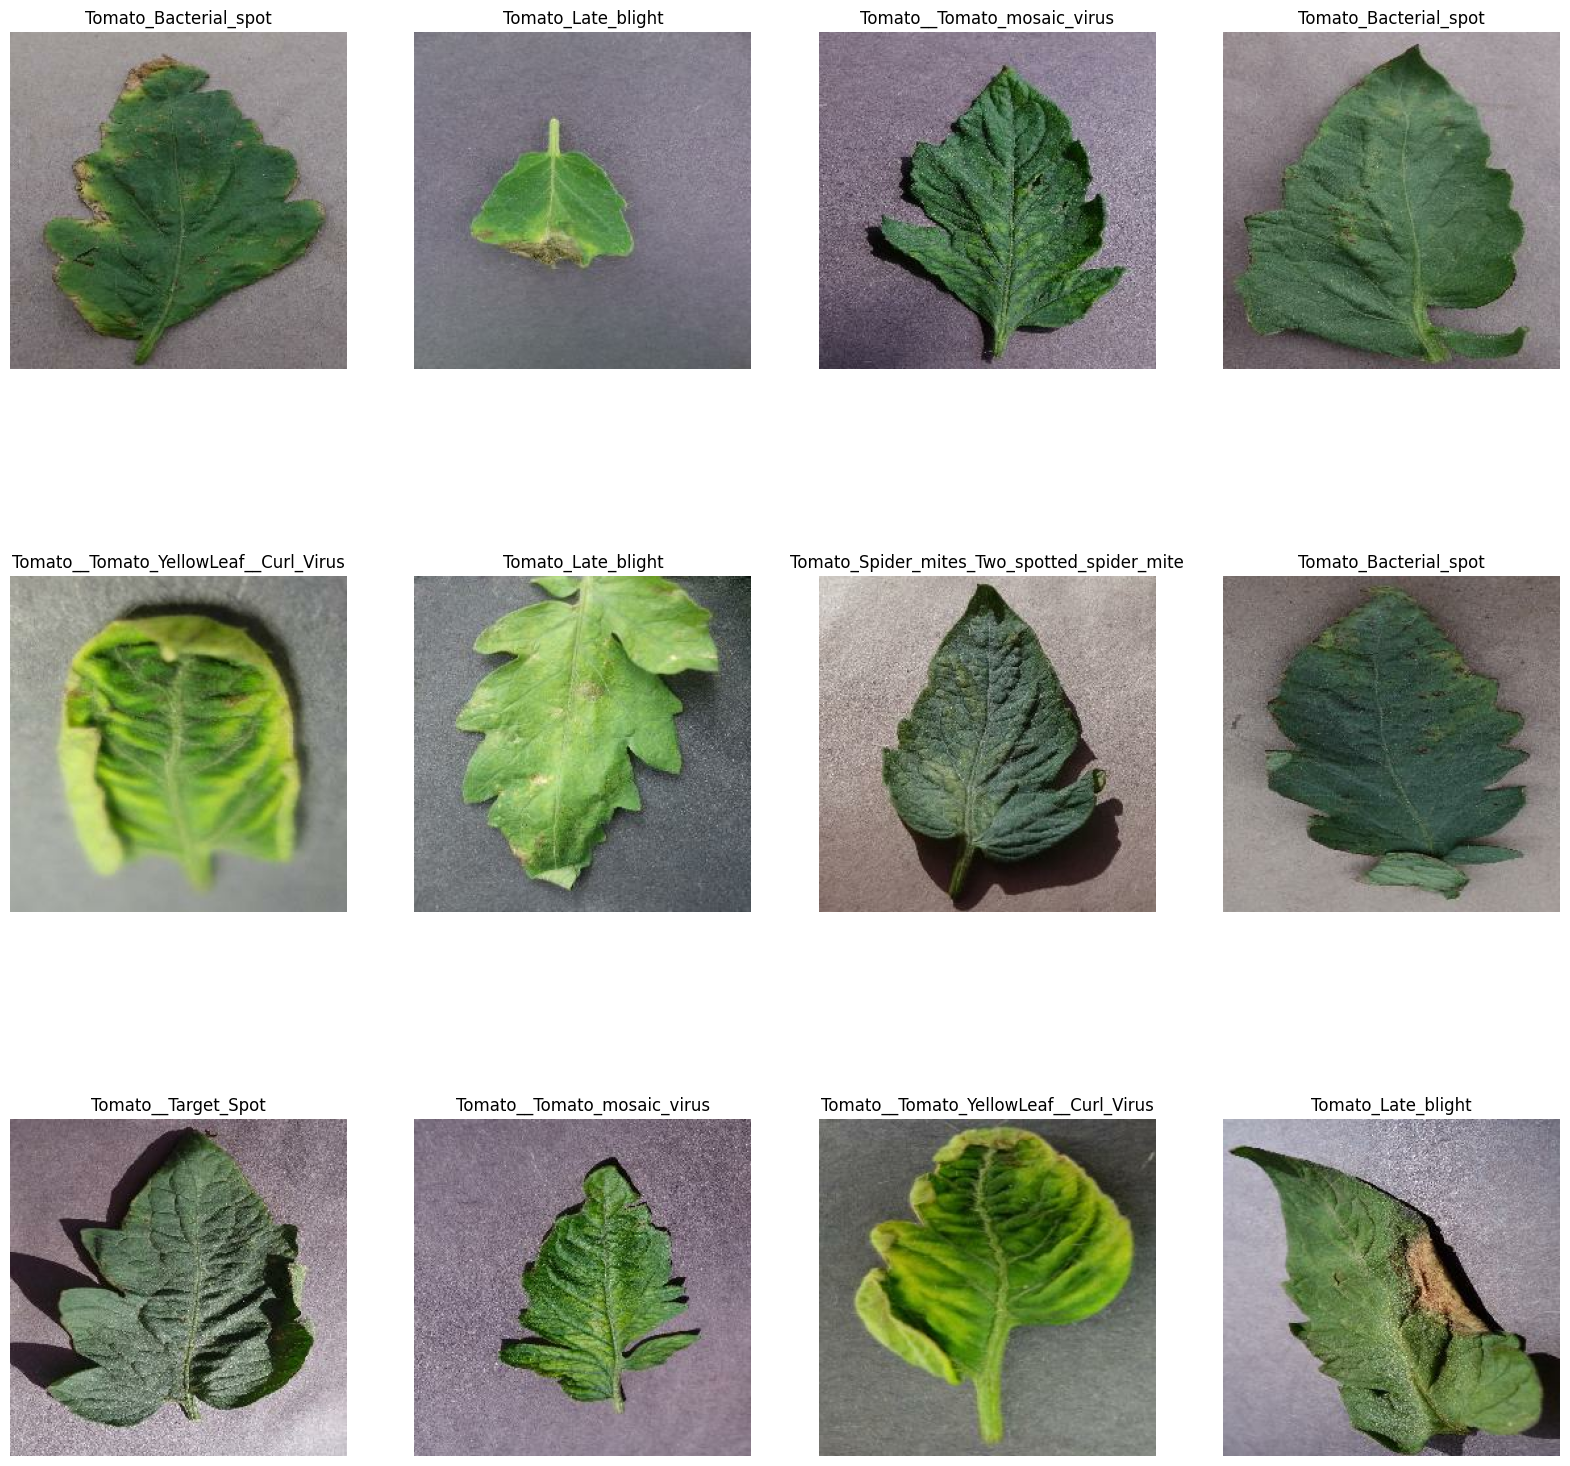

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [43]:
def split_ds(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle_size=10000,shuffle=True):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*train_split)
    train_ds=dataset.take(train_size)
    test_size=int(ds_size*test_split)
    test_ds=dataset.skip(train_size).take(test_size)
    val_ds=dataset.skip(train_size).skip(test_size)
    return train_ds,test_ds,val_ds

In [44]:
train_ds,test_ds,val_ds=split_ds(dataset)

In [45]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

400
50
51


In [46]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [47]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [48]:
#Make more data to train
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [49]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [50]:
#Build model
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

In [58]:
#Build model
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 10
model = tf.keras.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [59]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [62]:
history=model.fit(
    train_ds,
    epochs=30,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 331s 827ms/step - accuracy: 0.3636 - loss: 1.7674 - val_accuracy: 0.5345 - val_loss: 1.3859
Epoch 2/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 316s 790ms/step - accuracy: 0.5746 - loss: 1.2392 - val_accuracy: 0.4525 - val_loss: 1.7448
Epoch 3/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 287s 717ms/step - accuracy: 0.6731 - loss: 0.9241 - val_accuracy: 0.7194 - val_loss: 0.8871
Epoch 4/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 272s 680ms/step - accuracy: 0.7617 - loss: 0.6883 - val_accuracy: 0.6747 - val_loss: 1.0942
Epoch 5/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 281s 701ms/step - accuracy: 0.8169 - loss: 0.5054 - val_accuracy: 0.7126 - val_loss: 0.8279
Epoch 6/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 295s 737ms/step - accuracy: 0.8547 - loss: 0.4223 - val_accuracy: 0.7728 - val_loss: 0.6782
Epoch 7/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 273s 683ms/step - accuracy: 0.8719 - loss: 0.3559 - val_accuracy: 0.6927 - val_loss: 0.9901
Epoch 8/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 277s 692ms/step - accuracy: 0.8889 -

In [63]:
score = model.evaluate(test_ds)
score

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.9472 - loss: 0.1456


[0.16446366906166077, 0.9424999952316284]

In [64]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [67]:
len(acc)

30

Text(0.5, 1.0, 'Training and Validation Accuracy')

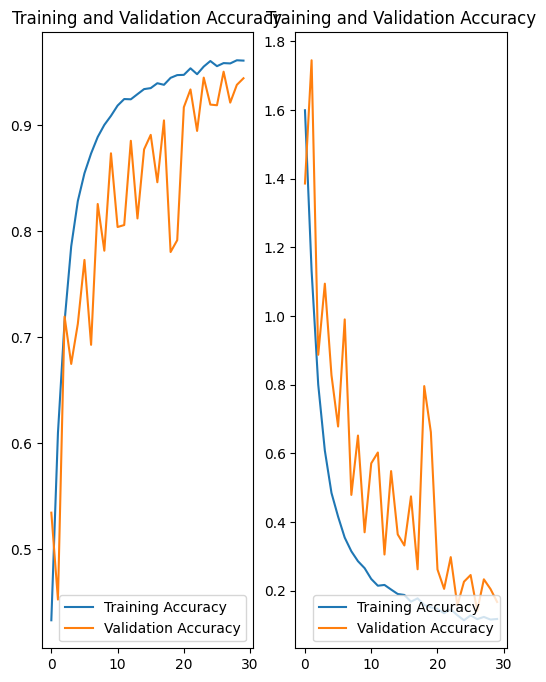

In [68]:
plt.figure(figsize=(6,8))
plt.subplot(1,2,1)
plt.plot(range(30),acc,label="Training Accuracy")
plt.plot(range(30),val_acc,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(30),loss,label="Training Accuracy")
plt.plot(range(30),val_loss,label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Tomato__Target_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
predicted label: Tomato__Target_Spot


2024-05-09 14:32:45.376587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


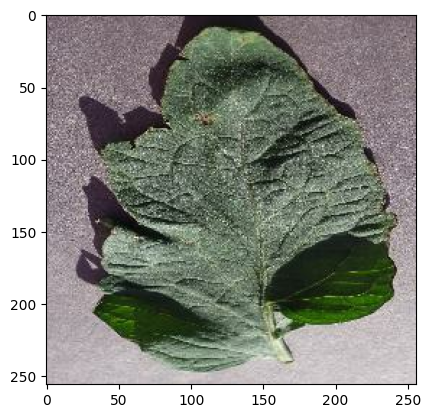

In [69]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [70]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-05-09 14:33:38.785761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


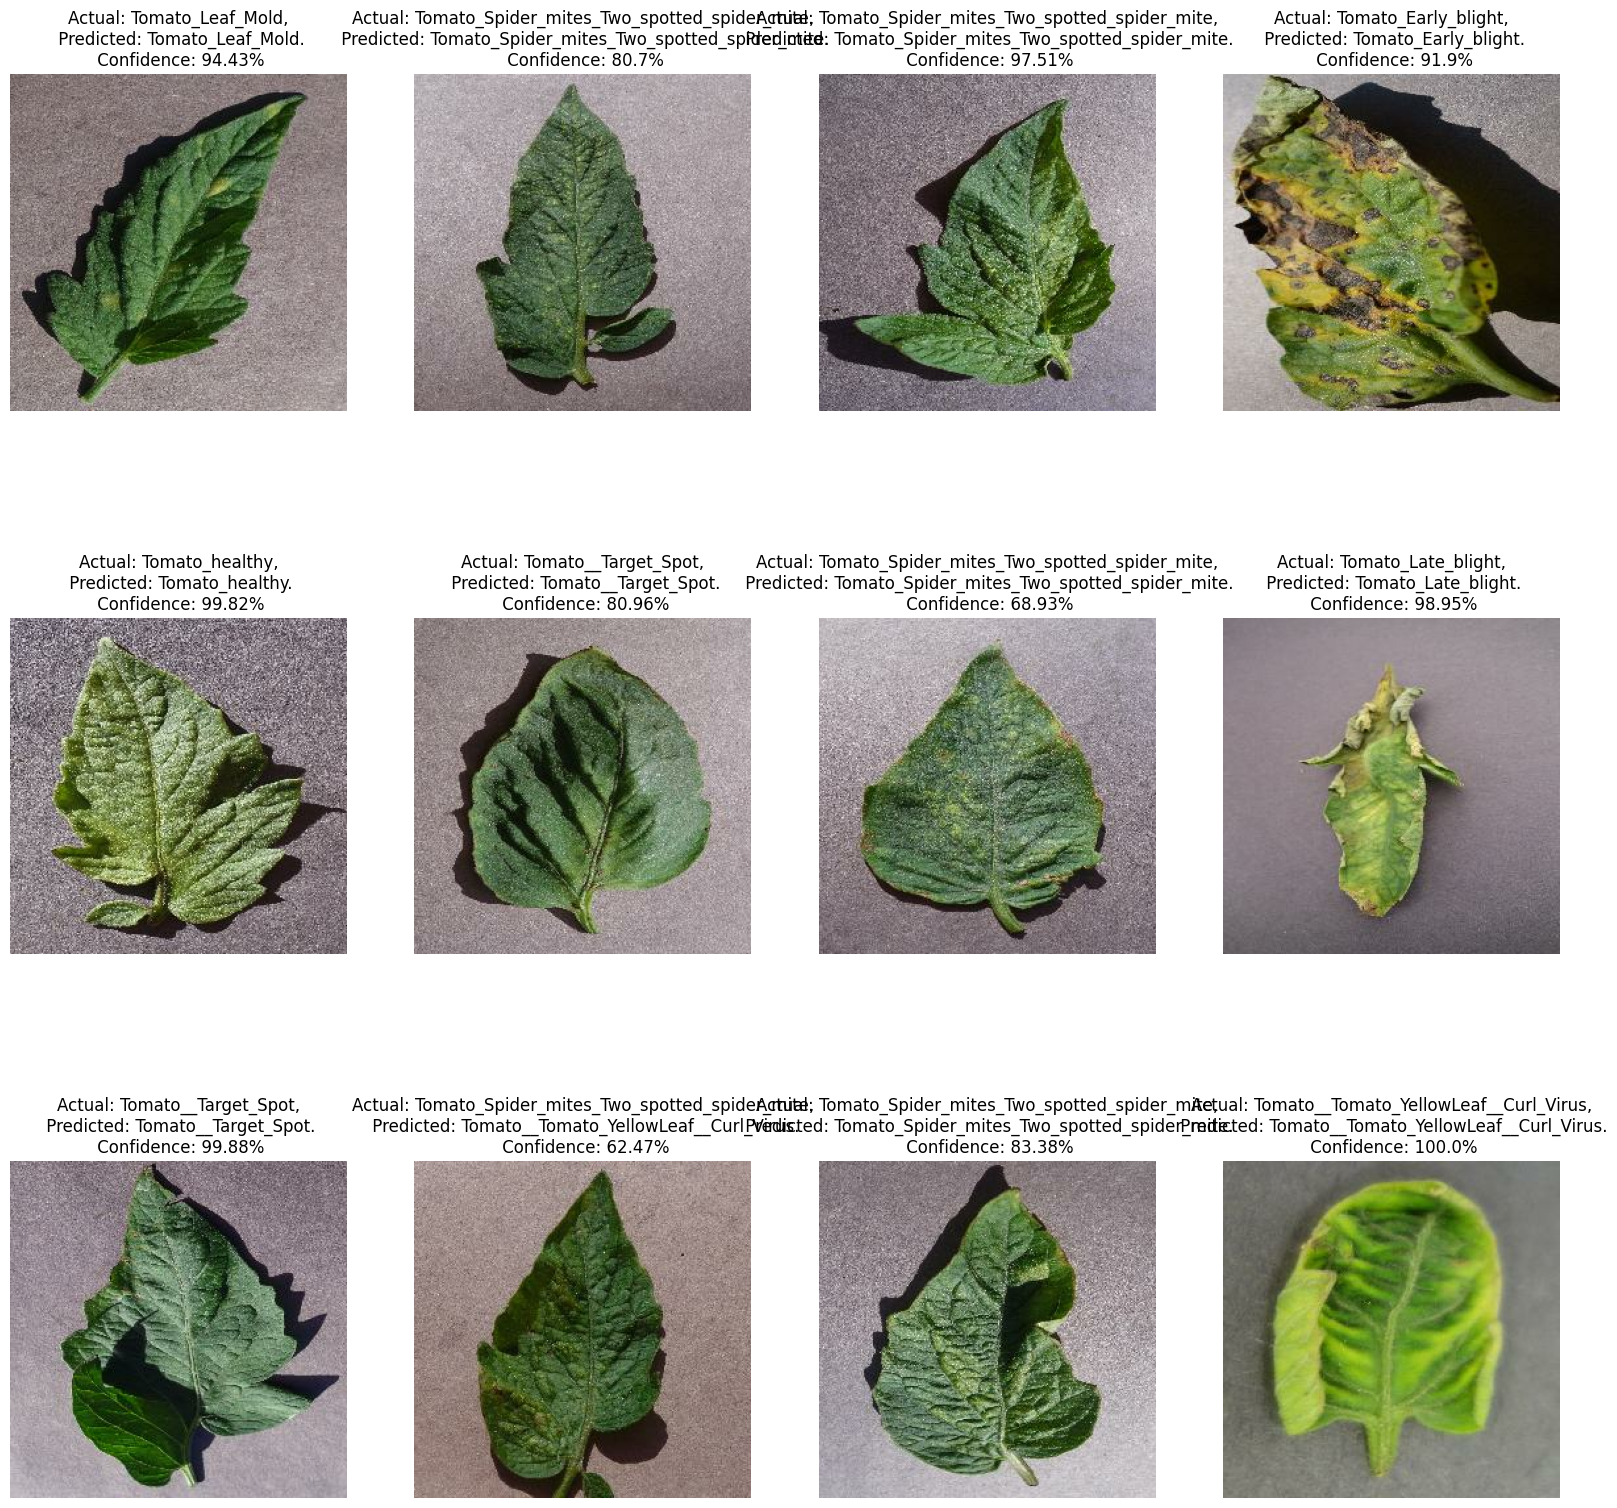

In [72]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [73]:
import os
from tensorflow.keras.models import save_model

save_dir = 'Models_Tomato'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model.save(os.path.join(save_dir, 'my_model_tomato.keras'))
print(os.listdir(save_dir))


['my_model_tomato.keras']


In [75]:
from tensorflow.keras.models import load_model
import os

# Directory where the model is saved
save_dir = 'Models_Tomato'

# Load the model
loaded_model = load_model(os.path.join(save_dir, 'my_model_tomato.keras'))

# Check model summary
model.export(os.path.join(save_dir))

INFO:tensorflow:Assets written to: Models_Tomato/assets


INFO:tensorflow:Assets written to: Models_Tomato/assets


Saved artifact at 'Models_Tomato'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_87')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  11133224336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11133224720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22816855184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22816856144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22816855952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22816856912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22816856720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22816857680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22816857488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22816858448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22816858256: TensorSpec(shape=(), dtype=tf.resource, 